# Exercise: Moveout of earthquakes

### Import modules

Here we provide you with the most important modules and functions already. 

In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
%matplotlib widget

In [30]:
import pickle 
import os

import pandas as pd
import numpy as np

from obspy import read
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, locations2degrees

import matplotlib.pyplot as plt

def calculate_distance(lon1, lat1, lon2, lat2):
    distance, _, _ = gps2dist_azimuth(lat1, lon1, lat2, lon2)
    return distance / 1000  # Convert to kilometers

def calculate_distance_degrees(lon1, lat1, lon2, lat2):
    dist_deg = locations2degrees(lat1, lon1, lat2, lon2)
    return dist_deg

def get_phases_and_arrivals(lon1, lat1, lon2, lat2, depth, bg_model="ak135", phase_list=["P", "S"]):
    dist = calculate_distance_degrees(lon1, lat1, lon2, lat2)
    model = TauPyModel(model=bg_model)

    travel_times = model.get_travel_times(
        source_depth_in_km=depth, 
        distance_in_degree=dist,
        # phase_list=phase_list,
    )

    # print(travel_times)
    arrival = [(tt.time, tt.name) for tt in travel_times]
    # print(lon1, lat1, lon2, lat2, depth, dist, arrival)
    try:
        arrivals, phases = zip(*arrival)
    except ValueError:
        arrivals, phases = [], []

    return phases, arrivals

### Download data using [ObspyDMT](https://github.com/kasra-hosseini/obspyDMT?tab=readme-ov-file#synthetic-seismograms)

Here we are using a command line in our notebook. 

In [31]:
! obspyDMT --datapath data_fiji_island --min_mag 6.8 --min_date 2014-07-21 --max_date 2014-07-22 --event_catalog NEIC_USGS --data_source IRIS --min_azi 50 --max_azi 55 --min_epi 94 --max_epi 100 --cha BHZ --instrument_correction
# ! obspyDMT --datapath data_rhum_rum_iran --min_mag 6.8 --min_date 2013-04-16  --max_date 2013-04-17 --event_catalog NEIC_USGS --data_source EIDA --net YV --min_azi 50 --max_azi 55 --min_epi 94 --max_epi 100 --cha BHZ --instrument_correction


--------------------------------------------------------------------------------
		   obspyDMT (obspy Data Management Tool)

	Python Toolbox for Retrieving, Processing and Management of
			Large Seismological Datasets

:copyright:
The ObsPy Development Team (devs@obspy.org)

Developed by Kasra Hosseini
email: kasra.hosseinizad@earth.ox.ac.uk

:license:
GNU General Public License, Version 3
(http://www.gnu.org/licenses/gpl-3.0-standalone.html)
--------------------------------------------------------------------------------


obspyDMT primary mode: event_based


Event(s) are based on:	NEIC_USGS
#Divisions: 0

Assembling 1 xml files...
1,
cleaning up the temporary folder.

0.7618850069993641 sec to retrieve the event info form NEIC.

#N LAT       LON       DEP  DATETIME             MAG  AUTH  EV_ID              FLY  
--------------------------------------------------------------------------------
1   -19.802  -178.400  615  2014-07-21T14:54:41  6.9  None  20140721_145441.a  NAN
----------

Use obspyDMT's internal function to plot the moveout. (The figure is in the data_fiji_island folder.)

In [ ]:
! obspyDMT --datapath data_fiji_island --local --plot_waveform --plot_dir processed --plot_save="data_fiji_island/plot_waveform_moveout.png"


## Exercise 
Write your own moveout function only using the information from the downloaded event (and make it nicer than the obspyDMT function).

### 1. Read in the event information

Here we are reading a pickle file -- which might not be that common but is a useful format to know

In [3]:
events = "data_fiji_island/EVENTS-INFO/event_list_pickle"
# events = "data_rhum_rum_iran/EVENTS-INFO/event_list_pickle"

with open(events, "rb") as f:
    print(f)
    event_list = pickle.load(f)


<_io.BufferedReader name='data_fiji_island/EVENTS-INFO/event_list_pickle'>


### 2. Read in the station information 

Here we can red the file into a pandas dataframe.

In [ ]:
# Definition to help change numeric location codes to strings (e.g., 0.0 -> '00', 10.0 -> '10')
def format_location(loc):
    if pd.isna(loc) or loc == '':
        return ''
    elif isinstance(loc, (int, float)):
        return f"{int(loc):02d}"  # Convert to zero-padded string
    else:
        return str(loc)

station_info = "data_fiji_island/20140721_145441.a/info/station_event"
# station_info = "data_rhum_rum_iran/20130416_104420.a/info/station_event"

# Define proper column names based on the data structure
column_names = ['network', 'station', 'location', 'channel', 'station_lat', 'station_lon', 
                'station_elev', 'station_depth', 'data_source', 'event_id', 'event_lat', 
                'event_lon', 'event_depth', 'magnitude', 'unknown1', 'unknown2', 'unknown3', 'extra']

df_station = pd.read_csv(station_info, sep=",", header=None, names=column_names)

# Clean up the location column - replace NaN with empty string for consistency
df_station['location'] = df_station['location'].fillna('')

df_station['location'] = df_station['location'].apply(format_location)
# df_station['datetime'] = event_list[0]['datetime'] # we will need this later for plotting!

print(df_station.head())
print(df_station)

  network station location channel  station_lat  station_lon  station_elev  \
0      IU     CCM       00     BHZ    38.055700   -91.244600         171.0   
1      IU     CCM       10     BHZ    38.055700   -91.244600         171.0   
2      N4    P38B              BHZ    39.624802   -93.532097         248.0   
3      N4    P40B              BHZ    39.529800   -92.048302         320.0   
4      N4    R32B              BHZ    38.422501   -98.711098         568.0   

   station_depth data_source           event_id  event_lat  event_lon  \
0           51.0        IRIS  20140721_145441.a   -19.8015  -178.4001   
1           51.0        IRIS  20140721_145441.a   -19.8015  -178.4001   
2            0.0        IRIS  20140721_145441.a   -19.8015  -178.4001   
3            0.0        IRIS  20140721_145441.a   -19.8015  -178.4001   
4            0.0        IRIS  20140721_145441.a   -19.8015  -178.4001   

   event_depth  magnitude  unknown1  unknown2  unknown3  extra  
0       615.42        6.9  

### 3. Calculate the distance from earthquake to station

Since you already have a pandas dataframe with the station_info the easiest would be to add it to the dataframe. 

In [23]:
# Add a distance column by applying the calculate_distance function row by row
df_station['distance_km'] = df_station.apply(
    lambda row: calculate_distance(
        row['station_lon'], row['station_lat'], 
        row['event_lon'], row['event_lat']       
    ), 
    axis=1  # apply function to each row
)

df_station['distance_deg'] = df_station.apply(
    lambda row: calculate_distance_degrees(
        row['station_lon'], row['station_lat'], 
        row['event_lon'], row['event_lat']
    ),
    axis=1
)

# Display the updated dataframe with the new distance column
print("DataFrame with distance column:")
print(df_station[['station', 'distance_km', 'distance_deg']].head())


DataFrame with distance column:
  station   distance_km  distance_deg
0     CCM  11102.754629     99.907453
1     CCM  11102.754629     99.907453
2    P38B  10966.996413     98.697868
3    P40B  11085.031991     99.755247
4    R32B  10499.987165     94.507348


/tmp/ipykernel_37657/441072659.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  distance, _, _ = gps2dist_azimuth(lat1, lon1, lat2, lon2)


### 4. Load the waveforms and make a simple plot

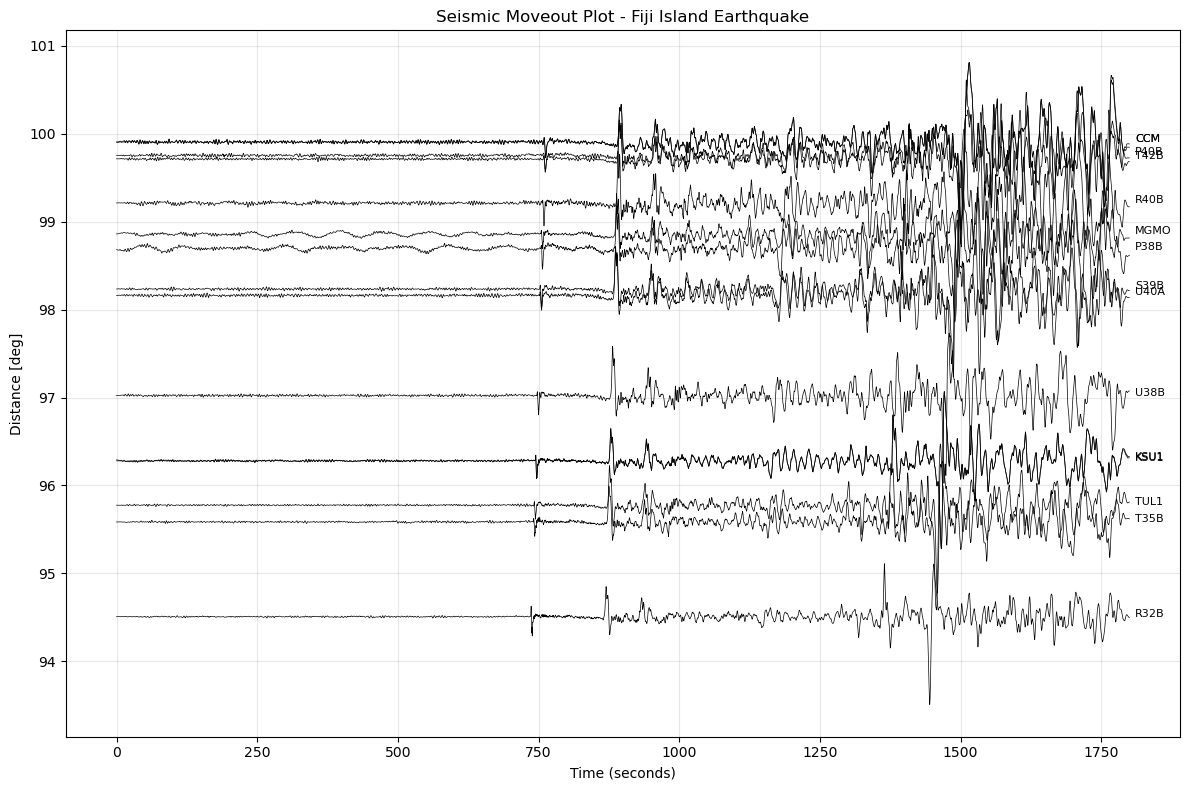

In [ ]:
plt.figure(figsize=(12, 8))

# Sort stations by distance for better moveout visualization
df_sorted = df_station.sort_values("distance_deg")

# The "trace_starttime" is only needed if the start times differ (which they do not in our cases).
trace_starttime = []

for index, row in df_station.iterrows():
    try:
        # Construct proper filename - handle empty location codes
        if row["location"] == "":
            filename = f"{row['network']}.{row['station']}..{row['channel']}"
        else:
            filename = (
                f"{row['network']}.{row['station']}.{row['location']}.{row['channel']}"
            )

        # Load the seismic data
        filepath = os.path.join(
            f"data_fiji_island/{row['event_id']}/processed", filename
        )
        
        stream = read(filepath)
        trace_data = stream[0].data
        trace_times = stream[0].times()  # Note: times() is a method, not an attribute
        trace_starttime.append(trace.stats.starttime)

        # Normalize the trace amplitude
        normalized_trace = trace_data / np.max(np.abs(trace_data))

        # Offset traces by distance for moveout visualization
        offset_trace = (
            normalized_trace + row["distance_deg"]
        )  # Scale offset as needed

        # Plot with time on x-axis
        plt.plot(
            trace_times,
            offset_trace,
            "k-",
            linewidth=0.5,
            label=f"{row['station']} ({row['distance_deg']:.0f} km)",
        )

        # Add station label
        plt.text(trace_times[-1] + 10, offset_trace[0], f"{row['station']}", fontsize=8)

    except Exception as e:
        print(f"Could not load data for {row['station']}: {e}")
        continue

plt.xlabel("Time (seconds)")
plt.ylabel("Distance [deg]")
plt.title("Seismic Moveout Plot - Fiji Island Earthquake")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

df_station["trace_starttime"] = trace_starttime

### 5. Add a filter to your plot 

Don't forget to detrend, demean and taper before filtering! 

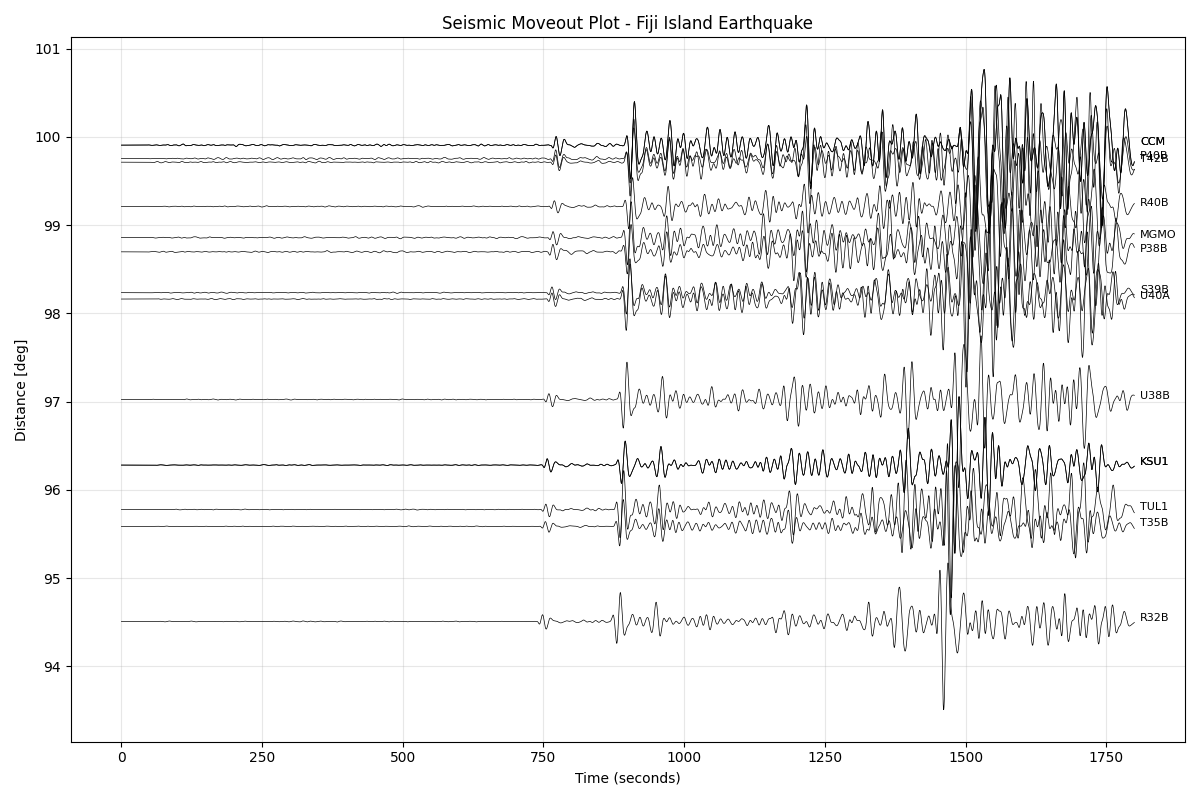

In [7]:
plt.figure(figsize=(12, 8))

for index, row in df_station.iterrows():
    try:
        # Construct proper filename - handle empty location codes
        if row["location"] == "":
            filename = f"{row['network']}.{row['station']}..{row['channel']}"
        else:
            filename = (
                f"{row['network']}.{row['station']}.{row['location']}.{row['channel']}"
            )

        # Load the seismic data
        filepath = os.path.join(
            f"data_fiji_island/{row['event_id']}/processed", filename
        )
        load_mseed = read(filepath)

        stream = load_mseed
        stream = stream.detrend("linear")  # Detrend the trace
        stream = stream.taper(max_percentage=0.05)  # Apply tapering
        stream = stream.filter("bandpass", freqmin=1/30.0, freqmax=1/10.0)
        trace_data = stream[0].data
        trace_times = stream[0].times()  # Note: times() is a method, not an attribute

        # Normalize the trace amplitude
        normalized_trace = trace_data / np.max(np.abs(trace_data))

        # Offset traces by distance for moveout visualization
        offset_trace = (
            normalized_trace + row["distance_deg"]
        )  # Scale offset as needed

        # Plot with time on x-axis
        plt.plot(
            trace_times,
            offset_trace,
            "k-",
            linewidth=0.5,
            label=f"{row['station']} ({row['distance_deg']:.0f} km)",
        )

        # Add station label
        plt.text(trace_times[-1] + 10, offset_trace[0], f"{row['station']}", fontsize=8)

    except Exception as e:
        print(f"Could not load data for {row['station']}: {e}")
        continue

plt.xlabel("Time (seconds)")
plt.ylabel("Distance [deg]")
plt.title("Seismic Moveout Plot - Fiji Island Earthquake")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6. Add with TauP the theoretical arrival times for P and S to your plot

#### General commands

There were rays for all but the following epicentral distances:
 [0.0, 360.0]


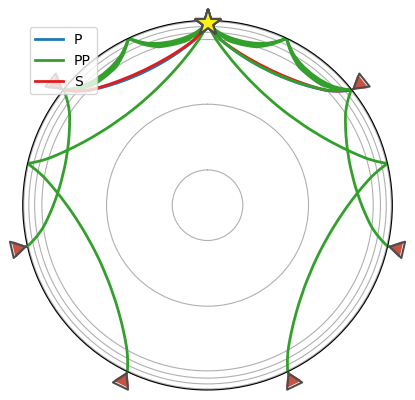

In [28]:
from obspy.taup import plot_ray_paths
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax = plot_ray_paths(source_depth=100, npoints=8, ax=ax, fig=fig, verbose=True,
                    phase_list=['P', 'S', 'PP'], legend=True)


In [9]:
from obspy.taup import TauPyModel

model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=55, distance_in_degree=67)
print(arrivals)

28 arrivals
	P phase arrival at 647.041 seconds
	pP phase arrival at 662.233 seconds
	sP phase arrival at 668.704 seconds
	PcP phase arrival at 674.865 seconds
	PP phase arrival at 794.992 seconds
	PKiKP phase arrival at 1034.098 seconds
	pPKiKP phase arrival at 1050.528 seconds
	sPKiKP phase arrival at 1056.721 seconds
	S phase arrival at 1176.948 seconds
	pS phase arrival at 1195.508 seconds
	SP phase arrival at 1196.830 seconds
	sS phase arrival at 1203.129 seconds
	PS phase arrival at 1205.421 seconds
	SKS phase arrival at 1239.090 seconds
	SKKS phase arrival at 1239.109 seconds
	ScS phase arrival at 1239.512 seconds
	SKiKP phase arrival at 1242.388 seconds
	pSKS phase arrival at 1260.314 seconds
	sSKS phase arrival at 1266.921 seconds
	SS phase arrival at 1437.427 seconds
	PKIKKIKP phase arrival at 1855.271 seconds
	SKIKKIKP phase arrival at 2063.564 seconds
	PKIKKIKS phase arrival at 2069.756 seconds
	SKIKKIKS phase arrival at 2277.857 seconds
	PKIKPPKIKP phase arrival at 2353.93

In [10]:
arrivals = model.get_travel_times(
    source_depth_in_km=100, distance_in_degree=45, phase_list=["P", "S"]
)
print(arrivals)

2 arrivals
	P phase arrival at 485.210 seconds
	S phase arrival at 876.834 seconds


#### Plot phases and arrivals in the moveout plot

In [11]:
# Add both phases and arrivals columns by applying the function row by row
df_station[["phases", "arrivals"]] = df_station.apply(
    lambda row: get_phases_and_arrivals(
        row["station_lon"],
        row["station_lat"],
        row["event_lon"],
        row["event_lat"],
        row["event_depth"],
        bg_model="iasp91",
        # phase_list=["P", "S"],
    ),
    axis=1,
    result_type="expand",
)

print(df_station['phases'].head())

0    (Pdiff, pP, sPdiff, PP, PKiKP, pPKiKP, SKiKP, ...
1    (Pdiff, pP, sPdiff, PP, PKiKP, pPKiKP, SKiKP, ...
2    (Pdiff, pP, sP, PP, PKiKP, pPKiKP, SKiKP, sPKi...
3    (Pdiff, pP, sPdiff, PP, PKiKP, pPKiKP, SKiKP, ...
4    (P, PcP, pP, sP, PP, PKiKP, pPKiKP, SKiKP, sPK...
Name: phases, dtype: object


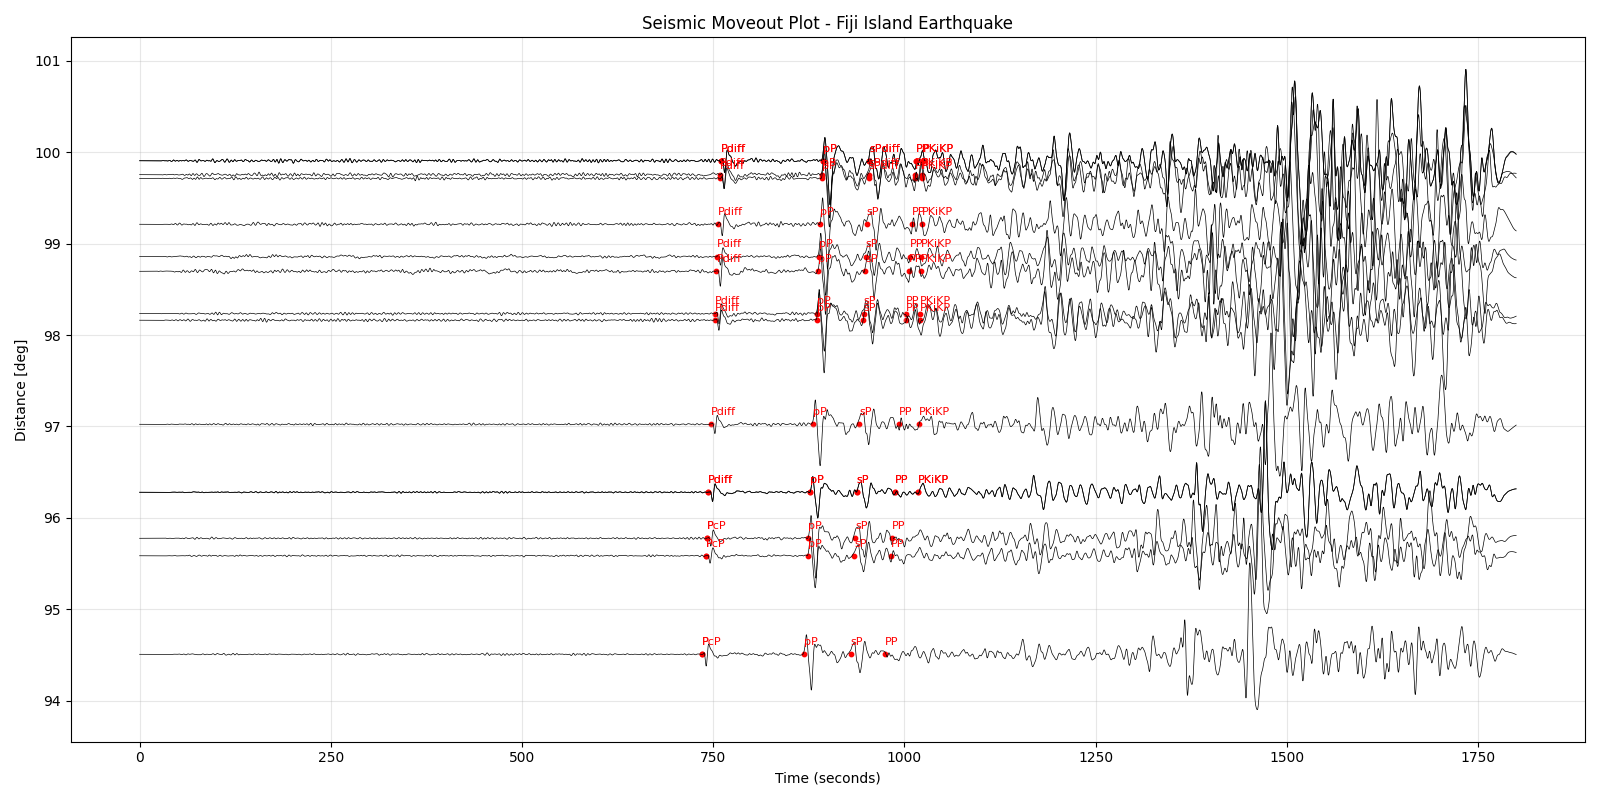

In [12]:
plt.figure(figsize=(16, 8))

# Sort stations by distance for better moveout visualization
df_sorted = df_station.sort_values("distance_deg")

number_of_phases = 5 # e.g. the first 5 phases

for index, row in df_station.iterrows():
    try:
        # Construct proper filename - handle empty location codes
        if row["location"] == "":
            filename = f"{row['network']}.{row['station']}..{row['channel']}"
        else:
            filename = (
                f"{row['network']}.{row['station']}.{row['location']}.{row['channel']}"
            )

        # Load the seismic data
        filepath = os.path.join(
            f"data_fiji_island/{row['event_id']}/processed", filename
        )
        load_mseed = read(filepath)

        stream = load_mseed
        stream = stream.detrend("linear")  # Detrend the trace
        stream = stream.taper(max_percentage=0.05)  # Apply tapering
        stream = stream.filter("bandpass", freqmin=1 / 50.0, freqmax=1 / 5.0)
        trace_data = stream[0].data
        trace_times = stream[0].times()  # Note: times() is a method, not an attribute

        # Normalize the trace amplitude
        normalized_trace = trace_data / np.max(np.abs(trace_data))

        # Offset traces by distance for moveout visualization
        offset_trace = (
            normalized_trace + row["distance_deg"]
        )  # Scale offset as needed

        # Plot with time on x-axis
        plt.plot(
            trace_times,
            offset_trace,
            "k-",
            linewidth=0.5,
            label=f"{row['station']} ({row['distance_deg']:.0f} km)",
        )

        for i in range(number_of_phases):
            phase = row["phases"][i]
            phase_arrival = row['arrivals'][i]

            plt.scatter(
                phase_arrival,
                offset_trace[0],
                color="red",
                s=10)

            # Add station label
            plt.text(
                phase_arrival,
                offset_trace[0] + 0.1,
                f"{phase}",
                fontsize=8,
                color="red",
            )

    except Exception as e:
        print(f"Could not load data for {row['station']}: {e}")
        continue

plt.xlabel("Time (seconds)")
plt.ylabel("Distance [deg]")
plt.title("Seismic Moveout Plot - Fiji Island Earthquake")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7. New dataset! 
Download an event from the RHUM-RUM experiment. Tip: use Wilber3 to scope for events during the deployment time of RHUM-RUM.  